In [29]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [30]:
# To reproduce same result everytime,
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Use the GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Class labels for CIFAR-10
classes = (
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
)

Device: cpu


In [31]:
# Normalize images using torchvision.transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Load datasets
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# DataLoader
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_set))
print("Test samples :", len(test_set))

# Quick sanity check
images, labels = next(iter(trainloader))
print("Batch images:", images.shape)  # [batch, 3, 32, 32]
print("Batch labels:", labels.shape)

Train samples: 50000
Test samples : 10000
Batch images: torch.Size([32, 3, 32, 32])
Batch labels: torch.Size([32])


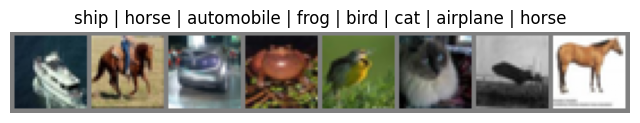

In [32]:
# Visualize training images
# unnormalizing before display
def imshow(img, title=None):
    # Unnormalize: x' = x*std + mean; here std=0.5 mean=0.5 => img/2 + 0.5
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Show 8 images
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images[:8], nrow=8)
title = " | ".join([classes[l] for l in labels[:8]])
imshow(grid, title=title)

In [33]:
# Simple CNN archetecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # Fully connected layers
        # CIFAR-10 size 32x32
        # After 3 pools: 32 -> 16 -> 8 -> 4
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#initializing model
net = SimpleCNN().to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [34]:
#definig loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [35]:
epochs = 10

def train_one_epoch(epoch_index):
    net.train()
    running_loss = 0.0
    
    #training loop
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()          # reset gradients
        outputs = net(inputs)          # forward pass
        loss = criterion(outputs, labels)
        loss.backward()                # backprop
        optimizer.step()               # update weights

        running_loss += loss.item()

        # Print every 100 mini-batches
        if (i + 1) % 100 == 0:
            avg_loss = running_loss / 100
            print(f"Epoch {epoch_index+1}/{epochs} | Batch {i+1} | Loss: {avg_loss:.4f}")
            running_loss = 0.0

for epoch in range(epochs):
    train_one_epoch(epoch)

Epoch 1/10 | Batch 100 | Loss: 2.0210
Epoch 1/10 | Batch 200 | Loss: 1.7569
Epoch 1/10 | Batch 300 | Loss: 1.6310
Epoch 1/10 | Batch 400 | Loss: 1.5592
Epoch 1/10 | Batch 500 | Loss: 1.4874
Epoch 1/10 | Batch 600 | Loss: 1.4226
Epoch 1/10 | Batch 700 | Loss: 1.3986
Epoch 1/10 | Batch 800 | Loss: 1.3268
Epoch 1/10 | Batch 900 | Loss: 1.2884
Epoch 1/10 | Batch 1000 | Loss: 1.2673
Epoch 1/10 | Batch 1100 | Loss: 1.2717
Epoch 1/10 | Batch 1200 | Loss: 1.2203
Epoch 1/10 | Batch 1300 | Loss: 1.1974
Epoch 1/10 | Batch 1400 | Loss: 1.1726
Epoch 1/10 | Batch 1500 | Loss: 1.1785
Epoch 2/10 | Batch 100 | Loss: 1.0922
Epoch 2/10 | Batch 200 | Loss: 1.0731
Epoch 2/10 | Batch 300 | Loss: 1.0514
Epoch 2/10 | Batch 400 | Loss: 1.0655
Epoch 2/10 | Batch 500 | Loss: 1.0057
Epoch 2/10 | Batch 600 | Loss: 1.0325
Epoch 2/10 | Batch 700 | Loss: 1.0195
Epoch 2/10 | Batch 800 | Loss: 1.0059
Epoch 2/10 | Batch 900 | Loss: 0.9957
Epoch 2/10 | Batch 1000 | Loss: 0.9589
Epoch 2/10 | Batch 1100 | Loss: 0.9772
Epoc

In [36]:
# Evaluating the Model
# torch.no_grad() to disable gradient calculation during evaluation
# torch.max() to find the predicted class with the highest score

def evaluate_accuracy():
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

acc = evaluate_accuracy()
print(f"Accuracy on 10,000 test images: {acc:.2f}%")

Accuracy on 10,000 test images: 74.38%


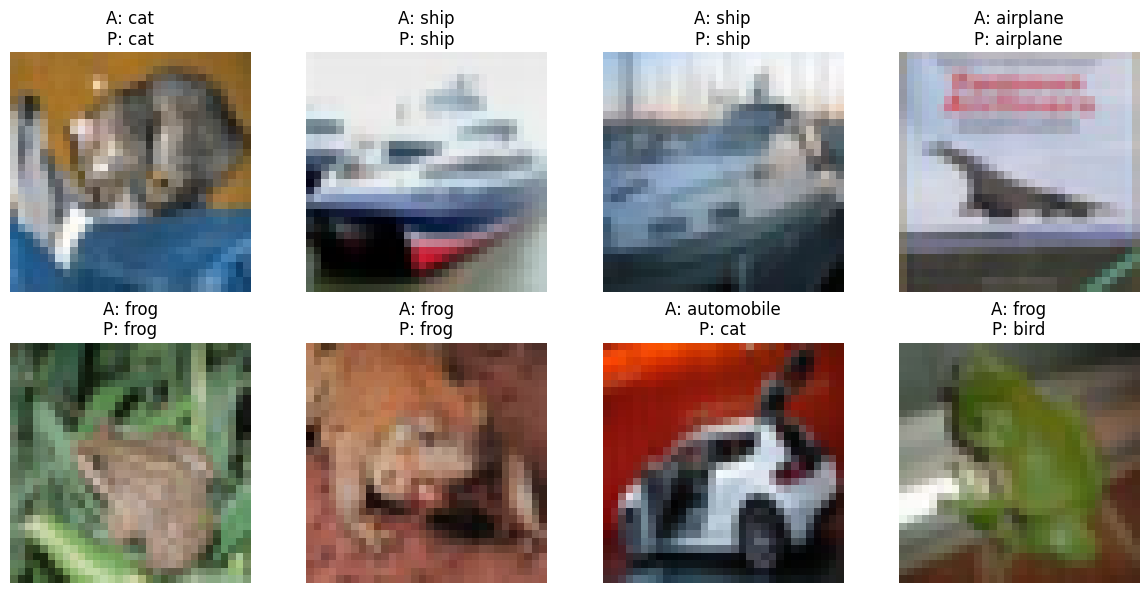

In [39]:
#Visualize Test Images with Actual and Predicted Labels
# Take one batch from test loader
# Take one batch from test loader
dataiter = iter(testloader)
images, labels = next(dataiter)

net.eval()
with torch.no_grad():
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"A: {classes[labels[i]]}\nP: {classes[predicted[i].cpu()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [40]:
# saving the model
os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/cnn_model.pth"
torch.save(net.state_dict(), model_path)
print("✅ Model saved successfully at:", model_path)


✅ Model saved successfully at: artifacts/cnn_model.pth
